### Example for creating synthetic seismic travel time measurement for watershed

1. Following the workflow code
2. Make it a function that we can do the forward modeling 

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
from pygimli.physics import TravelTimeManager
import pygimli.physics.traveltime as tt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygimli.meshtools as mt

# Setup package path for development
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()

# Add the parent directory to Python path
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import PyHydroGeophysX modules
from PyHydroGeophysX.model_output.modflow_output import MODFLOWWaterContent
from PyHydroGeophysX.core.interpolation import ProfileInterpolator, create_surface_lines
from PyHydroGeophysX.core.mesh_utils import MeshCreator
from PyHydroGeophysX.petrophysics.velocity_models import HertzMindlinModel, DEMModel

In [2]:
output_dir = "results/seismic_example"
os.makedirs(output_dir, exist_ok=True)

## Long seismic profile

In [3]:
print("Step 1: Follow the workflow to create the mesh and model...")

# These would be your actual data files
data_dir = "data/"
modflow_dir = os.path.join(data_dir, "modflow")

# Load domain information from files
# (Replace with your actual file paths)
idomain = np.loadtxt(os.path.join(data_dir, "id.txt"))
top = np.loadtxt(os.path.join(data_dir, "top.txt"))
porosity = np.load(os.path.join(data_dir, "Porosity.npy"))

Water_Content = np.load(os.path.join(data_dir, "Watercontent.npy"))

water_content = Water_Content[50]
print(water_content.shape)


# Step 3: Set up profile for 2D section

# Define profile endpoints
point1 = [115, 70]  # [col, row]
point2 = [95, 180]  # [col, row]

# Initialize profile interpolator
interpolator = ProfileInterpolator(
    point1=point1,
    point2=point2,
    surface_data=top,
    origin_x=569156.2983333333,
    origin_y=4842444.17,
    pixel_width=1.0,
    pixel_height=-1.0,
    num_points = 400
)



# Interpolate water content to profile
water_content_profile = interpolator.interpolate_3d_data(water_content)

# Interpolate porosity to profile
porosity_profile = interpolator.interpolate_3d_data(porosity)

Step 1: Follow the workflow to create the mesh and model...
(14, 194, 157)


In [4]:
print("Step 2: Creating geometry for the seismic refraction survey...")

# Load structure layers
bot = np.load(os.path.join(data_dir, "bot.npy"))

# Process layers to get structure
structure = interpolator.interpolate_layer_data([top] + bot.tolist())

# Create surface lines
# Indicate the layer for the structure regolith, fractured bedrock and fresh bedrock
top_idx=int(0)
mid_idx=int(4)
bot_idx=int(12)
surface, line1, line2 = create_surface_lines(
    L_profile=interpolator.L_profile,
    structure=structure,
    top_idx=0,
    mid_idx=4,
    bot_idx=12
)

# Create mesh
mesh_creator = MeshCreator(quality=32)
mesh, geom = mesh_creator.create_from_layers(
    surface=surface,
    layers=[line1, line2],
    bottom_depth= np.min(line2[:,1])-10 #50.0
)

Step 2: Creating geometry for the seismic refraction survey...


(<Axes: >, None)

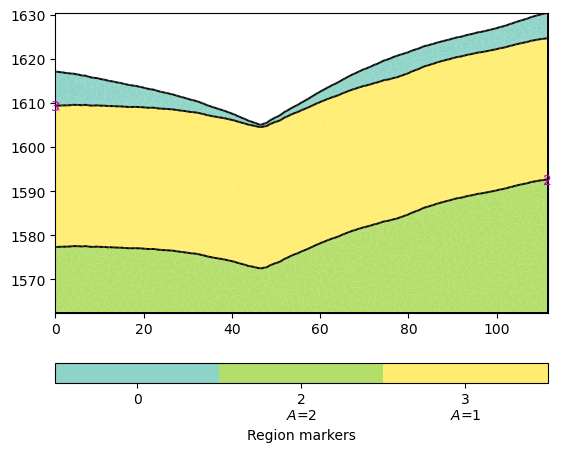

In [5]:
pg.show(geom)

In [6]:
numberGeophones = 90
shotDistance = 5

sensors = np.linspace(1,110, numberGeophones)

scheme = pg.physics.traveltime.createRAData(sensors,shotDistance=shotDistance)

# Adapt sensor positions to slope
pos = np.zeros((numberGeophones,2))
               

for i in range(numberGeophones):
    minusx = np.abs(surface[:,0]-sensors[i])
    index = np.where(minusx== np.amin(minusx))
    new_x = surface[index,0]
    new_y = surface[index,1]
    pos[i, 0] = new_x
    pos[i, 1] = new_y


scheme.setSensors(pos)

C:\Users\HChen8\AppData\Local\Temp\ipykernel_22568\2399746456.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[i, 0] = new_x
C:\Users\HChen8\AppData\Local\Temp\ipykernel_22568\2399746456.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[i, 1] = new_y


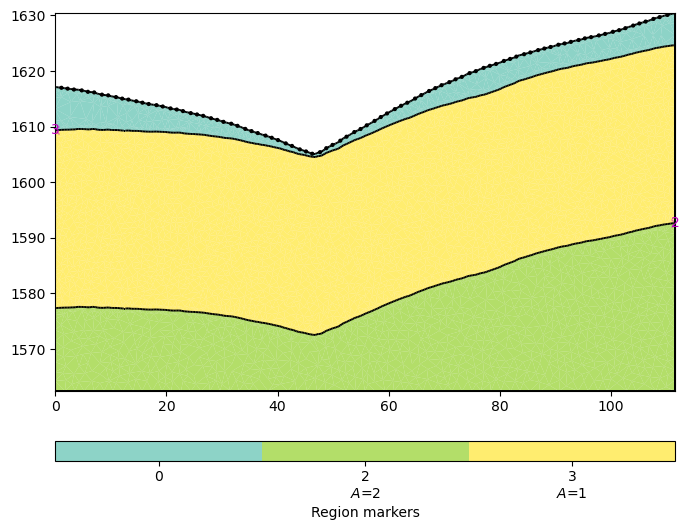

In [7]:
fig = plt.figure(figsize=[8,6])

ax = fig.add_subplot(1,1,1)
pg.show(geom,ax = ax)
pg.viewer.mpl.drawSensors(ax, scheme.sensors(), diam=0.5,
                         facecolor='black', edgecolor='black')

In [8]:
# Step 6: Interpolate data to mesh
print("Step 6: Interpolating data to mesh...")

ID1 = porosity_profile.copy()
ID1[:mid_idx] = 0 #regolith
ID1[mid_idx:bot_idx] = 3 # fractured bedrock
ID1[bot_idx:] = 2 # fresh bedrock

# Get mesh centers and markers
mesh_centers = np.array(mesh.cellCenters())
mesh_markers = np.array(mesh.cellMarkers())

# Interpolate porosity to mesh
porosity_mesh = interpolator.interpolate_to_mesh(
    property_values=porosity_profile,
    depth_values=structure,
    mesh_x=mesh_centers[:, 0],
    mesh_y=mesh_centers[:, 1],
    mesh_markers=mesh_markers,
    ID=ID1, # Use ID1 to indicate the layers for interpolation
    layer_markers = [0,3,2],

)

# Interpolate water content to mesh
wc_mesh = interpolator.interpolate_to_mesh(
    property_values=water_content_profile,
    depth_values=structure,
    mesh_x=mesh_centers[:, 0],
    mesh_y=mesh_centers[:, 1],
    mesh_markers=mesh_markers,
    ID=ID1, # Use ID1 to indicate the layers for interpolation
    layer_markers = [0,3,2],

)

print("Step 7: Calculating saturation...")

# Ensure porosity is not zero to avoid division by zero
porosity_safe = np.maximum(porosity_mesh, 0.01)
saturation = np.clip(wc_mesh / porosity_safe, 0.0, 1.0)

Step 6: Interpolating data to mesh...
Step 7: Calculating saturation...


In [9]:
# Step 9: Convert to P wave velocity using petrophysical model
print("Step9: Converting to P wave velocity ..")
marker_labels = [0, 3, 2] # top. mid, bottom layers (example values)

# Initialize velocity models
hm_model = HertzMindlinModel(critical_porosity=0.4, coordination_number=6.0)
dem_model = DEMModel()

# Initialize velocity model
velocity_mesh = np.zeros_like(wc_mesh)




top_mask = (mesh_markers == marker_labels[0])
top_bulk_modulus = 30.0  # GPa
top_shear_modulus = 20.0  # GPa
top_mineral_density = 2650  # kg/m³
top_depth = 1.0  # m

# Get Vp values using Hertz-Mindlin model
Vp_high, Vp_low = hm_model.calculate_velocity(
    porosity=porosity_mesh[top_mask],
    saturation=saturation[top_mask],
    bulk_modulus=top_bulk_modulus,
    shear_modulus=top_shear_modulus,
    mineral_density=top_mineral_density,
    depth=top_depth
)

# Use average of high and low bounds
velocity_mesh[top_mask] = (Vp_high + Vp_low) / 2



mid_mask = (mesh_markers == marker_labels[1])

mid_bulk_modulus = 50.0  # GPa
mid_shear_modulus = 35.0 # GPa
mid_mineral_density = 2670  # kg/m³
mid_aspect_ratio = 0.05

# Get Vp values using DEM model
_, _, Vp = dem_model.calculate_velocity(
    porosity=porosity_mesh[mid_mask],
    saturation=saturation[mid_mask],
    bulk_modulus=mid_bulk_modulus,
    shear_modulus=mid_shear_modulus,
    mineral_density=mid_mineral_density,
    aspect_ratio=mid_aspect_ratio
)

velocity_mesh[mid_mask] = Vp

bot_mask = (mesh_markers == marker_labels[2])
bot_bulk_modulus = 55  # GPa
bot_shear_modulus = 50  # GPa
bot_mineral_density = 2680  # kg/m³
bot_aspect_ratio = 0.03

# Get Vp values using DEM model
_, _, Vp = dem_model.calculate_velocity(
    porosity=porosity_mesh[bot_mask],
    saturation=saturation[bot_mask],
    bulk_modulus=bot_bulk_modulus,
    shear_modulus=bot_shear_modulus,
    mineral_density=bot_mineral_density,
    aspect_ratio=bot_aspect_ratio
)

velocity_mesh[bot_mask] = Vp

Step9: Converting to P wave velocity ..


In [10]:
mgr = TravelTimeManager()
datasrt = mgr.simulate(slowness=1.0 / velocity_mesh, scheme=scheme, mesh=mesh,
                    noiseLevel=0.05, noiseAbs=0.00001, seed=1334
                    ,verbose=True)
datasrt.save(os.path.join(output_dir, "synthetic_seismic_data_long.dat"))

23/05/25 - 09:19:02 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.002002676198374358 0.06435431843645598


1

<Axes: xlabel='Distance (m)', ylabel='Traveltime (s)'>

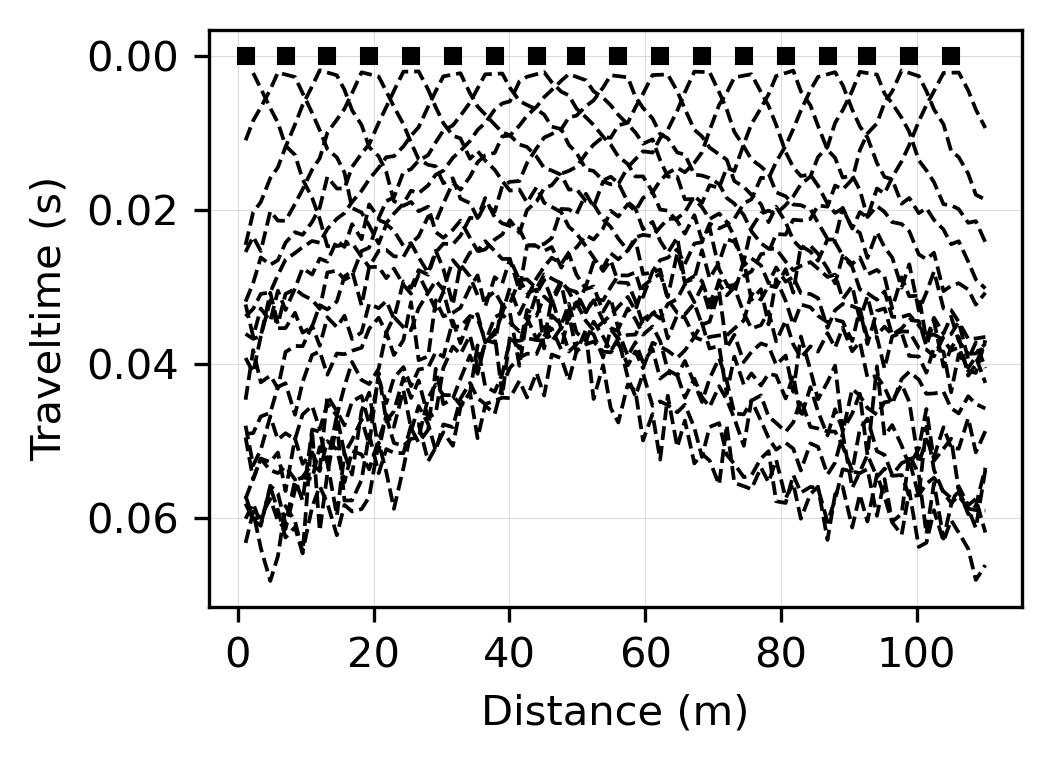

In [11]:
def drawFirstPicks(ax, data, tt=None, plotva=False, **kwargs):
    """Plot first arrivals as lines.
    
    Parameters
    ----------
    ax : matplotlib.axes
        axis to draw the lines in
    data : :gimliapi:`GIMLI::DataContainer`
        data containing shots ("s"), geophones ("g") and traveltimes ("t")
    tt : array, optional
        traveltimes to use instead of data("t")
    plotva : bool, optional
        plot apparent velocity instead of traveltimes
    
    Return
    ------
    ax : matplotlib.axes
        the modified axis
    """
    # Extract coordinates
    px = pg.x(data)
    gx = np.array([px[int(g)] for g in data("g")])
    sx = np.array([px[int(s)] for s in data("s")])
    
    # Get traveltimes
    if tt is None:
        tt = np.array(data("t"))
    if plotva:
        tt = np.absolute(gx - sx) / tt
    
    # Find unique source positions    
    uns = np.unique(sx)
    
    # Override kwargs with clean, minimalist style
    kwargs['color'] = 'black'
    kwargs['linestyle'] = '--'
    kwargs['linewidth'] = 0.9
    kwargs['marker'] = None  # No markers on the lines
    
    # Plot for each source
    for i, si in enumerate(uns):
        ti = tt[sx == si]
        gi = gx[sx == si]
        ii = gi.argsort()
        
        # Plot line
        ax.plot(gi[ii], ti[ii], **kwargs)
        
        # Add source marker as black square at top
        ax.plot(si, 0.0, 's', color='black', markersize=4, 
                markeredgecolor='black', markeredgewidth=0.5)
    
    # Clean grid style
    ax.grid(True, linestyle='-', linewidth=0.2, color='lightgray')
    
    # Set proper axis labels with units
    if plotva:
        ax.set_ylabel("Apparent velocity (m s$^{-1}$)")
    else:
        ax.set_ylabel("Traveltime (s)")
    
    ax.set_xlabel("Distance (m)")
    

    

    
    # Invert y-axis for traveltimes
    ax.invert_yaxis()

    return ax

# Usage
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300) 
drawFirstPicks(ax, datasrt)

In [12]:
TT = pg.physics.traveltime.TravelTimeManager()
mesh_inv = TT.createMesh(datasrt, paraMaxCellSize=2, quality=32, paraDepth = 50.0)
TT.invert(datasrt, mesh = mesh_inv,lam=50,
          zWeight=0.2,vTop=500, vBottom=5500,
          verbose=1, limits=[300., 8000.])

23/05/25 - 09:19:52 - pyGIMLi - INFO - Found 1 regions.
23/05/25 - 09:19:52 - pyGIMLi - INFO - Found 1 regions.
23/05/25 - 09:19:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
23/05/25 - 09:19:52 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
23/05/25 - 09:19:52 - pyGIMLi - INFO - Create gradient starting model. 500: 5500
23/05/25 - 09:19:52 - pyGIMLi - INFO - Created startmodel from forward operator: 5132, min/max=0.000182/0.002000
23/05/25 - 09:19:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x000001989E987BF0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000199DAE098F0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000199EC935460>
min/max (data): 0.0019/0.07
min/max (error): 4.31%/6.13%
min/max (start model): 1.8e-04/0.002
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   66.64
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    1.57 (dPhi = 97.33%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.95 (dPhi = 35.83%) lam: 50.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.95)                   #
################################################################################


5132 [673.3893740472461,...,2873.6205415997383]

In [13]:
cov = TT.standardizedCoverage()
pos = np.array(mesh_inv.cellCenters())


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import griddata

def fill_holes_2d(pos, cov, grid_resolution=100):
    """
    Fill holes (0 values) surrounded by 1 values in 2D scattered data.
    
    Parameters:
    -----------
    pos : ndarray of shape (n, 3)
        Position array where first two columns are x,y coordinates
    cov : ndarray of shape (n,)
        Coverage values at each point (0 or 1)
    grid_resolution : int
        Resolution of the grid for interpolation
        
    Returns:
    --------
    filled_cov : ndarray of shape (n,)
        Updated coverage values with holes filled
    """
    # Extract only the first two columns (x, y) from pos
    pos_2d = pos[:, :2]
    
    # Extract min and max coordinates for grid boundaries
    min_coords = np.min(pos_2d, axis=0)
    max_coords = np.max(pos_2d, axis=0)
    
    # Create a regular 2D grid
    x = np.linspace(min_coords[0], max_coords[0], grid_resolution)
    y = np.linspace(min_coords[1], max_coords[1], grid_resolution)
    X, Y = np.meshgrid(x, y)
    
    # Interpolate scattered data to regular grid
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
    grid_cov = griddata(pos_2d, cov, grid_points, method='nearest').reshape(X.shape)
    
    # Convert to binary
    binary_grid = (grid_cov > 0.5)
    
    # Fill holes using binary_fill_holes from scipy
    filled_grid = ndimage.binary_fill_holes(binary_grid)
    
    # Convert back to original data type
    filled_grid = filled_grid.astype(float)
    
    # Interpolate back to original scattered points
    filled_cov = griddata(grid_points, filled_grid.ravel(), pos_2d, method='nearest')
    
    return filled_cov

# Example usage
# Assuming you have your data loaded as pos and cov
# cov = np.array([0, 1, 0, ...])  # Your original coverage values

# Apply the hole filling function
filled_cov = fill_holes_2d(pos, cov)



In [15]:
def createTriangles(mesh):
    """Generate triangle objects for later drawing.

    Creates triangle for each 2D triangle cell or 3D boundary.
    Quads will be split into two triangles. Result will be cached into mesh._triData.

    Parameters
    ----------
    mesh : :gimliapi:`GIMLI::Mesh`
        2D mesh or 3D mesh

    Returns
    -------
    x : numpy array
        x position of nodes
    y : numpy array
        x position of nodes
    triangles : numpy array Cx3
        cell indices for each triangle, quad or boundary face
    z : numpy array
        z position for given indices
    dataIdx : list of int
        List of indices for a data array
    """
    if hasattr(mesh, '_triData'):
        if hash(mesh) == mesh._triData[0]:
            return mesh._triData[1:]

    x = pg.x(mesh)
    y = pg.y(mesh)
    z = pg.z(mesh)
    #    x.round(1e-1)
    #    y.round(1e-1)

    if mesh.dim() == 2:
        ents = mesh.cells()
    else:
        ents = mesh.boundaries(mesh.boundaryMarkers() != 0)
        if len(ents) == 0:
            for b in mesh.boundaries():
                if b.leftCell() is None or b.rightCell() is None:
                    ents.append(b)

    triangles = []
    dataIdx = []

    for c in ents:
        triangles.append([c.node(0).id(), c.node(1).id(), c.node(2).id()])
        dataIdx.append(c.id())

        if c.shape().nodeCount() == 4:
            triangles.append([c.node(0).id(), c.node(2).id(), c.node(3).id()])
            dataIdx.append(c.id())

    mesh._triData = [hash(mesh), x, y, triangles, z, dataIdx]

    return x, y, triangles, z, dataIdx

In [16]:
x, y, triangles, _, dataIndex = createTriangles(mesh_inv)
z = pg.meshtools.cellDataToNodeData(mesh_inv,TT.model.array())

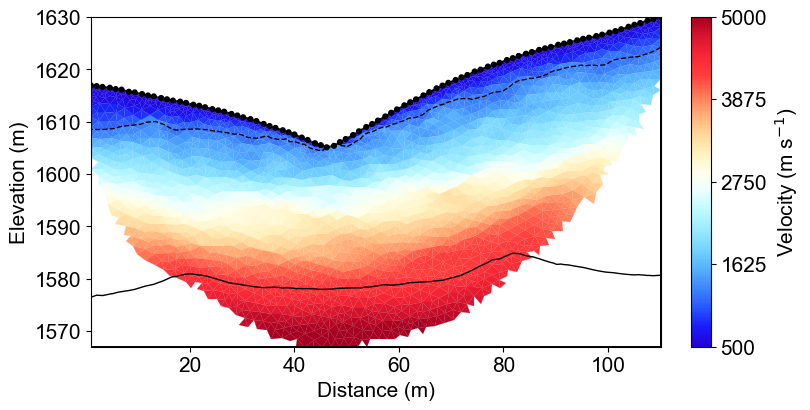

In [17]:
params = {'legend.fontsize': 15,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 15,
         'axes.titlesize':16,
         'xtick.labelsize':15,
         'ytick.labelsize':15}
import matplotlib.pylab as pylab
pylab.rcParams.update(params)

plt.rcParams["font.family"] = "Arial"

from palettable.lightbartlein.diverging import BlueDarkRed18_18
fixed_cmap = BlueDarkRed18_18.mpl_colormap

fig = plt.figure(figsize=[8,9])
ax1 = fig.add_subplot(1,1,1)
pg.show(mesh_inv,TT.model.array(),cMap=fixed_cmap,coverage = filled_cov,ax = ax1,label='Velocity (m s$^{-1}$)',
        xlabel="Distance (m)", ylabel="Elevation (m)",pad=0.3,cMin =500, cMax=5000
       ,orientation="vertical")


ax1.tricontour(x, y, triangles, z, levels=[1200], linewidths=1.0, colors='k', linestyles='dashed')
ax1.tricontour(x, y, triangles, z, levels=[4300], linewidths=1.0, colors='k', linestyles='-')


pg.viewer.mpl.drawSensors(ax1, datasrt.sensors(), diam=0.9,
                         facecolor='black', edgecolor='black')
fig.savefig(os.path.join(output_dir, 'seismic_velocity_long.tiff'), dpi=300, bbox_inches='tight')

## Short seismic profiles

In [18]:
ttData = tt.load("./results/workflow_example/synthetic_seismic_data.dat")
TT_short = pg.physics.traveltime.TravelTimeManager()
mesh_inv1 = TT_short.createMesh(ttData , paraMaxCellSize=2, quality=32, paraDepth = 30.0)
TT_short.invert(ttData , mesh = mesh_inv,lam=50,
          zWeight=0.2,vTop=500, vBottom=5500,
          verbose=1, limits=[300., 8000.])

23/05/25 - 09:21:00 - pyGIMLi - INFO - Found 1 regions.
23/05/25 - 09:21:00 - pyGIMLi - INFO - Found 1 regions.
23/05/25 - 09:21:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
23/05/25 - 09:21:00 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
23/05/25 - 09:21:00 - pyGIMLi - INFO - Create gradient starting model. 500: 5500
23/05/25 - 09:21:00 - pyGIMLi - INFO - Created startmodel from forward operator: 5132, min/max=0.000182/0.002000
23/05/25 - 09:21:00 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x00000199EC6C7880>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000199ECAA7A60>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000199EC797CA0>
min/max (data): 0.0014/0.06
min/max (error): 4.35%/6.41%
min/max (start model): 1.8e-04/0.002
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   15.78
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    2.08 (dPhi = 85.11%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.10 (dPhi = 41.80%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.97 (dPhi = 9.80%) lam: 50.0


################################################################################
#                  Abort c

5132 [559.8633875191574,...,2664.164029767927]

In [21]:
x1, y1, triangles1, _, dataIndex1 = createTriangles(mesh_inv)
z1 = pg.meshtools.cellDataToNodeData(mesh_inv,np.array(TT_short.model))
pos = np.array(mesh_inv.cellCenters())
filled_cov1 = fill_holes_2d(pos, TT_short.standardizedCoverage())

In [22]:
np.array(TT_short.model)

array([ 559.86338752,  646.66532374,  576.40124138, ..., 2698.53599368,
       2681.02932368, 2664.16402977])

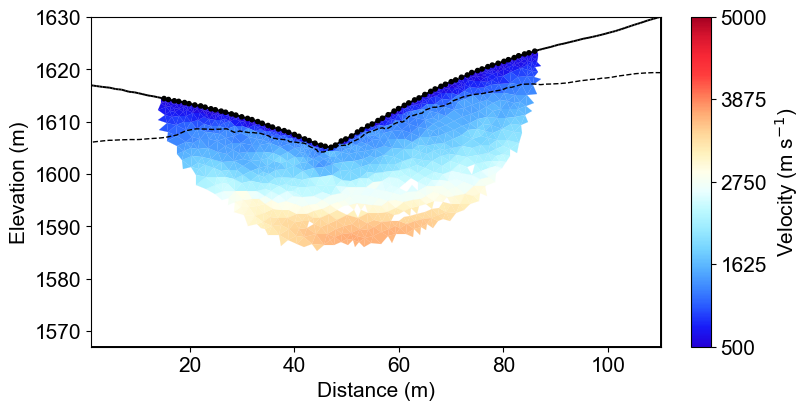

In [23]:
params = {'legend.fontsize': 15,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 15,
         'axes.titlesize':16,
         'xtick.labelsize':15,
         'ytick.labelsize':15}
import matplotlib.pylab as pylab
pylab.rcParams.update(params)

plt.rcParams["font.family"] = "Arial"

from palettable.lightbartlein.diverging import BlueDarkRed18_18
fixed_cmap = BlueDarkRed18_18.mpl_colormap

fig = plt.figure(figsize=[8,9])
ax1 = fig.add_subplot(1,1,1)
pg.show(mesh_inv,TT_short.model.array(),cMap=fixed_cmap,coverage = TT_short.standardizedCoverage(),ax = ax1,label='Velocity (m s$^{-1}$)',
        xlabel="Distance (m)", ylabel="Elevation (m)",pad=0.3,cMin =500, cMax=5000
       ,orientation="vertical")


ax1.tricontour(x1, y1, triangles1, z1, levels=[1200], linewidths=1.0, colors='k', linestyles='dashed')



pg.viewer.mpl.drawSensors(ax1, ttData.sensors(), diam=0.8,
                         facecolor='black', edgecolor='black')
fig.savefig(os.path.join(output_dir, 'seismic_velocity_short.tiff'), dpi=300, bbox_inches='tight')